
## Indoor scene recognition

- Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g., corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information

- The aim of the project is to build an Indoor scene recognition model using Resnet CNN to detect the indoor scenes from the available dataset


### Import necessary libraries

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data
- I will be using os to load my data which is present in drive.
- The goal of the project is to train a model to classify indoor scenes.
- The Dataset has 67 categories like bedroom, kitchen, garage, game room, airport, salon etc. and each category has at least 100 images and 15,620 RGB images totally. The size of the data is 2GB.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/606 PROJECT')

data_dir  = 'Images'

classes = os.listdir(data_dir)
print(classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['church_inside', 'florist', 'greenhouse', 'pantry', 'bedroom', 'restaurant', 'concert_hall', 'children_room', 'meeting_room', 'toystore', 'office', 'gameroom', 'stairscase', 'corridor', 'laundromat', 'bowling', 'casino', 'bathroom', 'dentaloffice', 'bakery', 'classroom', 'dining_room', 'restaurant_kitchen', 'bookstore', 'laboratorywet', 'fastfood_restaurant', 'tv_studio', 'grocerystore', 'library', 'lobby', 'operating_room', 'cloister', 'jewelleryshop', 'shoeshop', 'prisoncell', 'clothingstore', 'studiomusic', 'poolinside', 'movietheater', 'hospitalroom', 'locker_room', 'computerroom', 'videostore', 'mall', 'artstudio', 'livingroom', 'hairsalon', 'gym', 'museum', 'kindergarden', 'garage', 'kitchen', 'nursery', 'waitingroom', 'closet', 'airport_inside', 'warehouse', 'bar', 'inside_bus', 'elevator', 'deli', 'winecellar', 'subway', 'buffet', 'inside_subway', 't

In [3]:
print("The categories : ", sorted(classes))
print("The categories of images : ", len(classes))

The categories :  ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']
The categories of images :  67


### TorchVision Package
-  Using TorchVision Package to load and Preapare the data. Also,compose function from transforms creates a series of transformation to the prepare the dataset. Resizing the image into 256,256 and transform to tensors.

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
images_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
data = ImageFolder(data_dir, transform = images_transform)

The image is of bookstore category


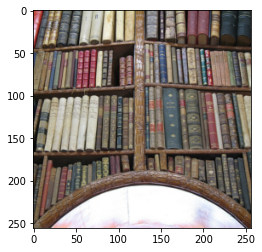

In [5]:
image, label = data[3077]
plt.imshow(image.permute(1, 2, 0))
print("The image is of", data.classes[label],"category")

In [6]:
print("Total no. of Images",len(data))

Total no. of Images 15620


### Train & Test Split
- Next, let's use the random_split helper function to set aside 3000 images for our test set.


In [9]:
train_data,test_data = random_split(data, [14620, 1000])
len(train_data),len(test_data)

(14620, 1000)

In [10]:
from torch.utils.data.dataloader import DataLoader

In [11]:
train_dataloader = torch.utils.data.DataLoader(
        train_data,
        batch_size=25,
        num_workers=4,
        shuffle=True,
        pin_memory = True,
    )
test_dataloader = torch.utils.data.DataLoader(
        test_data,
        batch_size=25*2,
        num_workers=4,
        shuffle=False,
        pin_memory = True,
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Evaluation Metric and Loss Function¶
- Let's first define the evaluation metric, its important to see how well our model is performing.The best. way to check is to the accuracy of the prediction.

- Loss functions are used to optimize the model during training. The objective is almost always to minimize the loss function. The lower the loss the better the model. Cross-Entropy loss is a most important cost function. It is used to optimize classification models.

- Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.
-  PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package.

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MultiClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

### ResNet
- A residual network (ResNet), is an artificial neural network that helps to build deeper neural network by utilizing skip connections or shortcuts to jump over some layers. It's skipping helps build deeper network layers without falling into the problem of vanishing gradients. 

### Transfer learning
- The main aim of transfer learning (TL) is to implement a model quickly. To solve the current problem, instead of creating neural network from scratch, the model will transfer the features it has learned from the different dataset that has performed the same task. This transaction is also known as knowledge transfer.
- Added a fully-connected layer for classification, specifying the classes and number of features and also tunned the parameters.


In [13]:
class ResNetModel(MultiClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(data.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNetModel()

### Using a GPU

- As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers.

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

### Model Training

In [15]:
@torch.no_grad()
def evaluate(model, test_dataloader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dataloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dataloader, test_dataloader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, test_dataloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)
to_device(model, device)

ResNetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

- Before training the model,need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). 

In [17]:
model = to_device(ResNetModel(), device)

- Print Summary of the model

In [18]:
from torchsummary import summary
summary(model, input_size=(3, 7,7), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           9,408
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]          36,864
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
       BasicBlock-11             [-1, 64, 2, 2]               0
           Conv2d-12             [-1, 64, 2, 2]          36,864
      BatchNorm2d-13             [-1, 64, 2, 2]             128
             ReLU-14             [-1, 6

### Evaluation 
- Now, Let's see how the model performs on the test set with the initial set of weights and biases.

In [19]:
evaluate(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.025999998673796654, 'val_loss': 4.2069292068481445}

- The initial accuracy is pretty low, so need to train the model. Let's train for 11 epochs and evaluate the performance for learning of 0.00006.

In [20]:
model_fit = fit(11,0.00006, model, train_dataloader, test_dataloader,torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: train_loss: 3.7029, val_loss: 3.5091, val_acc: 0.5950
Epoch 2: train_loss: 3.4522, val_loss: 3.4313, val_acc: 0.6910
Epoch 3: train_loss: 3.3652, val_loss: 3.4035, val_acc: 0.7170
Epoch 4: train_loss: 3.3180, val_loss: 3.3960, val_acc: 0.7440
Epoch 5: train_loss: 3.2902, val_loss: 3.3947, val_acc: 0.7490
Epoch 6: train_loss: 3.2736, val_loss: 3.3998, val_acc: 0.7380
Epoch 7: train_loss: 3.2636, val_loss: 3.4003, val_acc: 0.7740
Epoch 8: train_loss: 3.2571, val_loss: 3.4005, val_acc: 0.7800
Epoch 9: train_loss: 3.2527, val_loss: 3.4147, val_acc: 0.7760
Epoch 10: train_loss: 3.2488, val_loss: 3.4113, val_acc: 0.7770
Epoch 11: train_loss: 3.2471, val_loss: 3.4191, val_acc: 0.7810


### Plot Accuracy Vs Number of Epochs

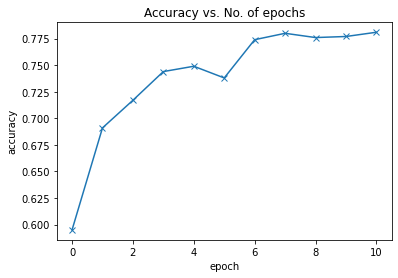

In [21]:
def plot_accuracies_model(model_fit):
    accuracies = [x['val_acc'] for x in model_fit]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies_model(model_fit)

In [22]:
evaluate(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.781000018119812, 'val_loss': 3.4190521240234375}

In [23]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)
    return data.classes[preds[0].item()]

Label: bookstore , Predicted: bookstore


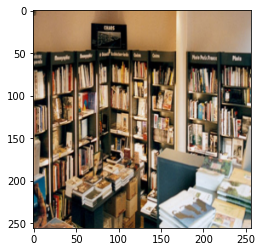

In [24]:
img, label = test_data[85]
plt.imshow(img.permute(1, 2, 0))
print('Label:', data.classes[label], ', Predicted:', predict_image(img, model))

In [25]:
loaded_model = model

The image resembles bar.


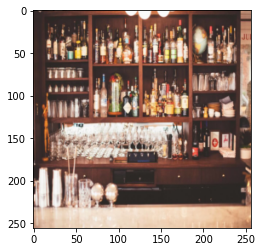

In [34]:
from PIL import Image
from pathlib import Path
image = Image.open(Path('./' + "bar.jpg"))
example_image = images_transform(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles children_room.


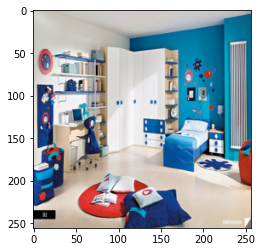

In [35]:
from PIL import Image
from pathlib import Path
image = Image.open(Path('./' + "bd.jpg"))
example_image = images_transform(image)
plt.imshow(example_image.permute(1, 2, 0))
print("The image resembles", predict_image(example_image, loaded_model) + ".")

In [31]:
def pytorch_predict(model, test_loader, device):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    count = 0
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)
    
    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for data1 in test_loader:
            inputs = [i.to(device) for i in data1[:-1]]
            labels = data1[-1].to(device)
            
            outputs = model(*inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)
    
    y_true = y_true.cpu().numpy()  
    _, y_pred = torch.max(all_outputs, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()
    for i in range(0,1000):
         if (data.classes[y_true[i].item()] != data.classes[y_pred[i].item()]):
             count+=1
             print("The scene is ",data.classes[y_true[i].item()],"but predicted as", data.classes[y_pred[i].item()])
    print("Total number of wrongly predicted observations from test data are :", count)

In [32]:
pytorch_predict(model, test_dataloader, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The scene is  movietheater but predicted as auditorium
The scene is  waitingroom but predicted as livingroom
The scene is  meeting_room but predicted as bar
The scene is  museum but predicted as toystore
The scene is  kindergarden but predicted as children_room
The scene is  museum but predicted as locker_room
The scene is  livingroom but predicted as dining_room
The scene is  locker_room but predicted as corridor
The scene is  restaurant but predicted as bar
The scene is  classroom but predicted as kitchen
The scene is  winecellar but predicted as bar
The scene is  library but predicted as bookstore
The scene is  airport_inside but predicted as kitchen
The scene is  fastfood_restaurant but predicted as casino
The scene is  corridor but predicted as locker_room
The scene is  museum but predicted as airport_inside
The scene is  artstudio but predicted as bar
The scene is  bar but predicted as museum
The scene is  auditorium but predicted as movietheater
The scene is  gameroom but predic